In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.utils import shuffle
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import torch
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.feature_selection import RFECV
import xgboost as xgb
import lightgbm as lgbm
from xgboost import XGBClassifier as XGB
from lightgbm import LGBMClassifier as LGBC
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score,cross_validate
from ray import tune
from concurrent.futures import ThreadPoolExecutor
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch
from torch.nn import functional as F
import torch.optim as optim
from tqdm.auto import tqdm
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import importlib
import all_merics
importlib.reload(all_merics)
from all_merics import *
import mlp_model
importlib.reload(mlp_model)
from mlp_model import *

In [2]:
df_exo = pd.read_csv('data/exo_gapen_descri_0106_sxnx.csv', index_col=0)
df_tox = pd.read_csv('data/tox_gapen_descri_0106_sxnx.csv', index_col=0)
df_all = pd.concat([df_exo, df_tox], axis=0)
df_all_random = shuffle(df_all,  random_state=1)
df_all_random.head()

,label,standard_smiles,sx_ave1,sx_ave2,sx_ave3,sx_ave4,sx_ave5,sx_ave6,sx_ave7,sx_ave8,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
939,0.0,CC(C)C(=O)OCC(C)c1ccccc1,90.396552,75.168831,103.873563,78.907692,71.632353,78.686275,84.588235,80.657895,...,0,0,0,0,0,0,0,0,0,0
355,1.0,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCc2cccs2)CC1,89.943925,84.810458,86.877551,87.665025,88.000000,78.128755,74.591954,78.641026,...,0,0,0,0,0,0,0,1,0,0
614,1.0,FC(F)OC(F)(F)C(F)Cl,78.842105,80.733333,57.250000,64.666667,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1535,1.0,Clc1ccc(-c2cc(Cl)cc(Cl)c2Cl)c(Cl)c1,180.222222,84.807692,129.275862,109.789474,114.277778,109.500000,68.750000,74.000000,...,0,0,0,0,0,0,0,0,0,0
337,1.0,NS(=O)(=O)c1cc2c(cc1Cl)NCNS2(=O)=O,172.800000,128.187500,148.402597,134.396552,113.875000,137.043478,79.714286,22.000000,...,0,2,0,0,0,0,0,0,0,0


In [3]:
col_list = list(df_all_random.columns.values)
gapen_all = ['sx_ave1', 'sx_ave2', 'sx_ave3', 'sx_ave4', 'sx_ave5', 'sx_ave6', 'sx_ave7', 'sx_ave8', 'sx_ave9', 'sx_ave10', 'sx_std1', 'sx_std2', 'sx_std3', 'sx_std4', 'sx_std5', 'sx_std6', 'sx_std7', 'sx_std8', 'sx_std9', 'sx_std10', 'nx_ave1', 'nx_ave2', 'nx_ave3', 'nx_ave4', 'nx_ave5', 'nx_ave6', 'nx_ave7', 'nx_ave8', 'nx_ave9', 'nx_ave10', 'nx_std1', 'nx_std2', 'nx_std3', 'nx_std4', 'nx_std5', 'nx_std6', 'nx_std7', 'nx_std8', 'nx_std9', 'nx_std10', 'oldnbe', 'oldstd', 'newnbe', 'newstd', 'max_gap', 'sx_ave1*sx_ave2', 'sx_ave1*sx_ave3', 'sx_ave1*sx_ave4', 'sx_ave1*sx_ave5', 'sx_ave1*sx_ave6', 'sx_ave1*sx_ave7', 'sx_ave1*sx_ave8', 'sx_ave1*sx_ave9', 'sx_ave1*sx_ave10', 'sx_ave2*sx_ave3', 'sx_ave2*sx_ave4', 'sx_ave2*sx_ave5', 'sx_ave2*sx_ave6', 'sx_ave2*sx_ave7', 'sx_ave2*sx_ave8', 'sx_ave2*sx_ave9', 'sx_ave2*sx_ave10', 'sx_ave3*sx_ave4', 'sx_ave3*sx_ave5', 'sx_ave3*sx_ave6', 'sx_ave3*sx_ave7', 'sx_ave3*sx_ave8', 'sx_ave3*sx_ave9', 'sx_ave3*sx_ave10', 'sx_ave4*sx_ave5', 'sx_ave4*sx_ave6', 'sx_ave4*sx_ave7', 'sx_ave4*sx_ave8', 'sx_ave4*sx_ave9', 'sx_ave4*sx_ave10', 'sx_ave5*sx_ave6', 'sx_ave5*sx_ave7', 'sx_ave5*sx_ave8', 'sx_ave5*sx_ave9', 'sx_ave5*sx_ave10', 'sx_ave6*sx_ave7', 'sx_ave6*sx_ave8', 'sx_ave6*sx_ave9', 'sx_ave6*sx_ave10', 'sx_ave7*sx_ave8', 'sx_ave7*sx_ave9', 'sx_ave7*sx_ave10', 'sx_ave8*sx_ave9', 'sx_ave8*sx_ave10', 'sx_ave9*sx_ave10', 'sx_std1*sx_std2', 'sx_std1*sx_std3', 'sx_std1*sx_std4', 'sx_std1*sx_std5', 'sx_std1*sx_std6', 'sx_std1*sx_std7', 'sx_std1*sx_std8', 'sx_std1*sx_std9', 'sx_std1*sx_std10', 'sx_std2*sx_std3', 'sx_std2*sx_std4', 'sx_std2*sx_std5', 'sx_std2*sx_std6', 'sx_std2*sx_std7', 'sx_std2*sx_std8', 'sx_std2*sx_std9', 'sx_std2*sx_std10', 'sx_std3*sx_std4', 'sx_std3*sx_std5', 'sx_std3*sx_std6', 'sx_std3*sx_std7', 'sx_std3*sx_std8', 'sx_std3*sx_std9', 'sx_std3*sx_std10', 'sx_std4*sx_std5', 'sx_std4*sx_std6', 'sx_std4*sx_std7', 'sx_std4*sx_std8', 'sx_std4*sx_std9', 'sx_std4*sx_std10', 'sx_std5*sx_std6', 'sx_std5*sx_std7', 'sx_std5*sx_std8', 'sx_std5*sx_std9', 'sx_std5*sx_std10', 'sx_std6*sx_std7', 'sx_std6*sx_std8', 'sx_std6*sx_std9', 'sx_std6*sx_std10', 'sx_std7*sx_std8', 'sx_std7*sx_std9', 'sx_std7*sx_std10', 'sx_std8*sx_std9', 'sx_std8*sx_std10', 'sx_std9*sx_std10', 'nx_ave1*nx_ave2', 'nx_ave1*nx_ave3', 'nx_ave1*nx_ave4', 'nx_ave1*nx_ave5', 'nx_ave1*nx_ave6', 'nx_ave1*nx_ave7', 'nx_ave1*nx_ave8', 'nx_ave1*nx_ave9', 'nx_ave1*nx_ave10', 'nx_ave2*nx_ave3', 'nx_ave2*nx_ave4', 'nx_ave2*nx_ave5', 'nx_ave2*nx_ave6', 'nx_ave2*nx_ave7', 'nx_ave2*nx_ave8', 'nx_ave2*nx_ave9', 'nx_ave2*nx_ave10', 'nx_ave3*nx_ave4', 'nx_ave3*nx_ave5', 'nx_ave3*nx_ave6', 'nx_ave3*nx_ave7', 'nx_ave3*nx_ave8', 'nx_ave3*nx_ave9', 'nx_ave3*nx_ave10', 'nx_ave4*nx_ave5', 'nx_ave4*nx_ave6', 'nx_ave4*nx_ave7', 'nx_ave4*nx_ave8', 'nx_ave4*nx_ave9', 'nx_ave4*nx_ave10', 'nx_ave5*nx_ave6', 'nx_ave5*nx_ave7', 'nx_ave5*nx_ave8', 'nx_ave5*nx_ave9', 'nx_ave5*nx_ave10', 'nx_ave6*nx_ave7', 'nx_ave6*nx_ave8', 'nx_ave6*nx_ave9', 'nx_ave6*nx_ave10', 'nx_ave7*nx_ave8', 'nx_ave7*nx_ave9', 'nx_ave7*nx_ave10', 'nx_ave8*nx_ave9', 'nx_ave8*nx_ave10', 'nx_ave9*nx_ave10', 'nx_std1*nx_std2', 'nx_std1*nx_std3', 'nx_std1*nx_std4', 'nx_std1*nx_std5', 'nx_std1*nx_std6', 'nx_std1*nx_std7', 'nx_std1*nx_std8', 'nx_std1*nx_std9', 'nx_std1*nx_std10', 'nx_std2*nx_std3', 'nx_std2*nx_std4', 'nx_std2*nx_std5', 'nx_std2*nx_std6', 'nx_std2*nx_std7', 'nx_std2*nx_std8', 'nx_std2*nx_std9', 'nx_std2*nx_std10', 'nx_std3*nx_std4', 'nx_std3*nx_std5', 'nx_std3*nx_std6', 'nx_std3*nx_std7', 'nx_std3*nx_std8', 'nx_std3*nx_std9', 'nx_std3*nx_std10', 'nx_std4*nx_std5', 'nx_std4*nx_std6', 'nx_std4*nx_std7', 'nx_std4*nx_std8', 'nx_std4*nx_std9', 'nx_std4*nx_std10', 'nx_std5*nx_std6', 'nx_std5*nx_std7', 'nx_std5*nx_std8', 'nx_std5*nx_std9', 'nx_std5*nx_std10', 'nx_std6*nx_std7', 'nx_std6*nx_std8', 'nx_std6*nx_std9', 'nx_std6*nx_std10', 'nx_std7*nx_std8', 'nx_std7*nx_std9', 'nx_std7*nx_std10', 'nx_std8*nx_std9', 'nx_std8*nx_std10', 'nx_std9*nx_std10', ]
gapen_10 = ['sx_ave1', 'sx_ave2', 'sx_ave3', 'sx_ave4', 'sx_ave5', 'sx_ave6', 'sx_ave7', 'sx_ave8', 'sx_ave9', 'sx_ave10']
gapen_20 = ['sx_ave1', 'sx_ave2', 'sx_ave3', 'sx_ave4', 'sx_ave5', 'sx_ave6', 'sx_ave7', 'sx_ave8', 'sx_ave9', 'sx_ave10', 'sx_std1', 'sx_std2', 'sx_std3', 'sx_std4', 'sx_std5', 'sx_std6', 'sx_std7', 'sx_std8', 'sx_std9', 'sx_std10',]
gapen_40 = ['sx_ave1', 'sx_ave2', 'sx_ave3', 'sx_ave4', 'sx_ave5', 'sx_ave6', 'sx_ave7', 'sx_ave8', 'sx_ave9', 'sx_ave10', 'sx_std1', 'sx_std2', 'sx_std3', 'sx_std4', 'sx_std5', 'sx_std6', 'sx_std7', 'sx_std8', 'sx_std9', 'sx_std10', 'nx_ave1', 'nx_ave2', 'nx_ave3', 'nx_ave4', 'nx_ave5', 'nx_ave6', 'nx_ave7', 'nx_ave8', 'nx_ave9', 'nx_ave10', 'nx_std1', 'nx_std2', 'nx_std3', 'nx_std4', 'nx_std5', 'nx_std6', 'nx_std7', 'nx_std8', 'nx_std9', 'nx_std10',]
gapen_nonbe = ['sx_ave1', 'sx_ave2', 'sx_ave3', 'sx_ave4', 'sx_ave5', 'sx_ave6', 'sx_ave7', 'sx_ave8', 'sx_ave9', 'sx_ave10', 'sx_std1', 'sx_std2', 'sx_std3', 'sx_std4', 'sx_std5', 'sx_std6', 'sx_std7', 'sx_std8', 'sx_std9', 'sx_std10', 'nx_ave1', 'nx_ave2', 'nx_ave3', 'nx_ave4', 'nx_ave5', 'nx_ave6', 'nx_ave7', 'nx_ave8', 'nx_ave9', 'nx_ave10', 'nx_std1', 'nx_std2', 'nx_std3', 'nx_std4', 'nx_std5', 'nx_std6', 'nx_std7', 'nx_std8', 'nx_std9', 'nx_std10', 'sx_ave1*sx_ave2', 'sx_ave1*sx_ave3', 'sx_ave1*sx_ave4', 'sx_ave1*sx_ave5', 'sx_ave1*sx_ave6', 'sx_ave1*sx_ave7', 'sx_ave1*sx_ave8', 'sx_ave1*sx_ave9', 'sx_ave1*sx_ave10', 'sx_ave2*sx_ave3', 'sx_ave2*sx_ave4', 'sx_ave2*sx_ave5', 'sx_ave2*sx_ave6', 'sx_ave2*sx_ave7', 'sx_ave2*sx_ave8', 'sx_ave2*sx_ave9', 'sx_ave2*sx_ave10', 'sx_ave3*sx_ave4', 'sx_ave3*sx_ave5', 'sx_ave3*sx_ave6', 'sx_ave3*sx_ave7', 'sx_ave3*sx_ave8', 'sx_ave3*sx_ave9', 'sx_ave3*sx_ave10', 'sx_ave4*sx_ave5', 'sx_ave4*sx_ave6', 'sx_ave4*sx_ave7', 'sx_ave4*sx_ave8', 'sx_ave4*sx_ave9', 'sx_ave4*sx_ave10', 'sx_ave5*sx_ave6', 'sx_ave5*sx_ave7', 'sx_ave5*sx_ave8', 'sx_ave5*sx_ave9', 'sx_ave5*sx_ave10', 'sx_ave6*sx_ave7', 'sx_ave6*sx_ave8', 'sx_ave6*sx_ave9', 'sx_ave6*sx_ave10', 'sx_ave7*sx_ave8', 'sx_ave7*sx_ave9', 'sx_ave7*sx_ave10', 'sx_ave8*sx_ave9', 'sx_ave8*sx_ave10', 'sx_ave9*sx_ave10', 'sx_std1*sx_std2', 'sx_std1*sx_std3', 'sx_std1*sx_std4', 'sx_std1*sx_std5', 'sx_std1*sx_std6', 'sx_std1*sx_std7', 'sx_std1*sx_std8', 'sx_std1*sx_std9', 'sx_std1*sx_std10', 'sx_std2*sx_std3', 'sx_std2*sx_std4', 'sx_std2*sx_std5', 'sx_std2*sx_std6', 'sx_std2*sx_std7', 'sx_std2*sx_std8', 'sx_std2*sx_std9', 'sx_std2*sx_std10', 'sx_std3*sx_std4', 'sx_std3*sx_std5', 'sx_std3*sx_std6', 'sx_std3*sx_std7', 'sx_std3*sx_std8', 'sx_std3*sx_std9', 'sx_std3*sx_std10', 'sx_std4*sx_std5', 'sx_std4*sx_std6', 'sx_std4*sx_std7', 'sx_std4*sx_std8', 'sx_std4*sx_std9', 'sx_std4*sx_std10', 'sx_std5*sx_std6', 'sx_std5*sx_std7', 'sx_std5*sx_std8', 'sx_std5*sx_std9', 'sx_std5*sx_std10', 'sx_std6*sx_std7', 'sx_std6*sx_std8', 'sx_std6*sx_std9', 'sx_std6*sx_std10', 'sx_std7*sx_std8', 'sx_std7*sx_std9', 'sx_std7*sx_std10', 'sx_std8*sx_std9', 'sx_std8*sx_std10', 'sx_std9*sx_std10', 'nx_ave1*nx_ave2', 'nx_ave1*nx_ave3', 'nx_ave1*nx_ave4', 'nx_ave1*nx_ave5', 'nx_ave1*nx_ave6', 'nx_ave1*nx_ave7', 'nx_ave1*nx_ave8', 'nx_ave1*nx_ave9', 'nx_ave1*nx_ave10', 'nx_ave2*nx_ave3', 'nx_ave2*nx_ave4', 'nx_ave2*nx_ave5', 'nx_ave2*nx_ave6', 'nx_ave2*nx_ave7', 'nx_ave2*nx_ave8', 'nx_ave2*nx_ave9', 'nx_ave2*nx_ave10', 'nx_ave3*nx_ave4', 'nx_ave3*nx_ave5', 'nx_ave3*nx_ave6', 'nx_ave3*nx_ave7', 'nx_ave3*nx_ave8', 'nx_ave3*nx_ave9', 'nx_ave3*nx_ave10', 'nx_ave4*nx_ave5', 'nx_ave4*nx_ave6', 'nx_ave4*nx_ave7', 'nx_ave4*nx_ave8', 'nx_ave4*nx_ave9', 'nx_ave4*nx_ave10', 'nx_ave5*nx_ave6', 'nx_ave5*nx_ave7', 'nx_ave5*nx_ave8', 'nx_ave5*nx_ave9', 'nx_ave5*nx_ave10', 'nx_ave6*nx_ave7', 'nx_ave6*nx_ave8', 'nx_ave6*nx_ave9', 'nx_ave6*nx_ave10', 'nx_ave7*nx_ave8', 'nx_ave7*nx_ave9', 'nx_ave7*nx_ave10', 'nx_ave8*nx_ave9', 'nx_ave8*nx_ave10', 'nx_ave9*nx_ave10', 'nx_std1*nx_std2', 'nx_std1*nx_std3', 'nx_std1*nx_std4', 'nx_std1*nx_std5', 'nx_std1*nx_std6', 'nx_std1*nx_std7', 'nx_std1*nx_std8', 'nx_std1*nx_std9', 'nx_std1*nx_std10', 'nx_std2*nx_std3', 'nx_std2*nx_std4', 'nx_std2*nx_std5', 'nx_std2*nx_std6', 'nx_std2*nx_std7', 'nx_std2*nx_std8', 'nx_std2*nx_std9', 'nx_std2*nx_std10', 'nx_std3*nx_std4', 'nx_std3*nx_std5', 'nx_std3*nx_std6', 'nx_std3*nx_std7', 'nx_std3*nx_std8', 'nx_std3*nx_std9', 'nx_std3*nx_std10', 'nx_std4*nx_std5', 'nx_std4*nx_std6', 'nx_std4*nx_std7', 'nx_std4*nx_std8', 'nx_std4*nx_std9', 'nx_std4*nx_std10', 'nx_std5*nx_std6', 'nx_std5*nx_std7', 'nx_std5*nx_std8', 'nx_std5*nx_std9', 'nx_std5*nx_std10', 'nx_std6*nx_std7', 'nx_std6*nx_std8', 'nx_std6*nx_std9', 'nx_std6*nx_std10', 'nx_std7*nx_std8', 'nx_std7*nx_std9', 'nx_std7*nx_std10', 'nx_std8*nx_std9', 'nx_std8*nx_std10', 'nx_std9*nx_std10', ]
descri = ['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3', 'HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolLogP', 'MolMR', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea']
# print(col_list)

In [4]:
def featurelabels(df, opt):
    features = df[opt]
    labels = df['label']
    selector = VarianceThreshold(0.0) #排除为0的特征
    features = selector.fit_transform(features)  # 会变成数组
    features = pd.DataFrame(features)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1,
                                                        stratify=labels)

    mean = X_train.mean(skipna=True)
    std = X_train.std(skipna=True) + 0.00001
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    X_train = X_train.fillna(0.0)
    X_test = X_test.fillna(0.0)

    X_train = torch.tensor(X_train.values).to(torch.float32)
    X_test = torch.tensor(X_test.values).to(torch.float32)
    y_train = torch.LongTensor(y_train.values)
    y_test = torch.LongTensor(y_test.values)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = featurelabels(df_all_random, gapen_all)
gapen_descri_list = [gapen_all, descri, gapen_all+descri]
gapen_descri_namelist = ['gapen_all', 'descri', 'gapen_all+descri']
weight = df_exo.shape[0]/df_tox.shape[0]

In [5]:
print(weight)
print(X_train.shape[1])
print(X_test.shape)
print(y_train[1])

2.81640625
225
torch.Size([1954, 225])
tensor(1)


特征筛选

In [6]:
config_lgbm_gapen = {'n_estimators': 320, 'learning_rate': 0.04269326560878588, 
                     'max_depth': 6, 'subsample': 0.7000000000000001,
                     'colsample_bytree': 0.9, 'reg_lambda': 2.5}
config_lgbm_descri = {'n_estimators': 480, 'learning_rate': 0.09034690531177264, 
                      'max_depth': 7, 'subsample': 0.9, 
                      'colsample_bytree': 0.8, 'reg_lambda': 2.5}
config_xgb_gapen = {'n_estimators': 384, 'eta': 0.11433808730262854, 'max_depth': 7, 
                    'min_child_weight': 1, 'gamma': 0, 'subsample': 0.9, 'colsample_bytree': 0.9,
                    'reg_lambda': 2.5, 'alpha': 0.6}
config_xgb_descri = {'n_estimators': 416, 'eta': 0.054890366192422504, 'max_depth': 6, 
                     'min_child_weight': 1, 'gamma': 0, 'subsample': 0.7, 'colsample_bytree': 0.8,
                     'reg_lambda': 1.0, 'alpha': 0.9}


In [7]:
def feature_selector(clf_str, config, datastr):
    if clf_str=="xgb":
        clf = XGB(**config, scale_pos_weight=weight, 
        eval_metric='auc', booster='gbtree', objective='binary:logistic',seed=1, tree_method='exact', n_jobs=10, random_state=1)
    if clf_str=="lgbm":
        clf = LGBC(**config, scale_pos_weight=weight, 
        objective='binary', boosting_type='gbdt', n_jobs=1, random_state=1)
    X_train, X_test, y_train, y_test = featurelabels(df_all_random, datastr)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    selector = RFECV(estimator=clf, min_features_to_select=10, step=5,cv=kfold,scoring='balanced_accuracy',
                verbose=1,n_jobs=10, importance_getter="feature_importances_")#
    selector.fit(X_train,y_train)
    score_val = selector.cv_results_['mean_test_score']
    print("RFECV over")
    # selector.support_
    X_train_w, X_test_w = selector.transform(X_train), selector.transform(X_test)
    print(X_train_w.shape, X_test_w.shape)
    return score_val,selector.support_, X_train_w, X_test_w


In [8]:
score_val_xgb_gapen,xgb_gapen_support, X_train_w_xgb_gapen, X_test_w_xgb_gapen = feature_selector("xgb", config_xgb_gapen, gapen_all)
score_val_xgb_descri,xgb_descri_support, X_train_w_xgb_descri, X_test_w_xgb_descri = feature_selector("xgb", config_xgb_descri, descri)
print(X_train_w_xgb_gapen.shape, X_train_w_xgb_descri.shape) #(7816, 50) (7816, 109)

Fitting estimator with 225 features.
Fitting estimator with 225 features.
Fitting estimator with 225 features.
Fitting estimator with 225 features.
Fitting estimator with 225 features.
Fitting estimator with 220 features.
Fitting estimator with 220 features.
Fitting estimator with 220 features.
Fitting estimator with 220 features.
Fitting estimator with 220 features.
Fitting estimator with 215 features.
Fitting estimator with 215 features.
Fitting estimator with 215 features.
Fitting estimator with 215 features.
Fitting estimator with 215 features.
Fitting estimator with 210 features.
Fitting estimator with 210 features.
Fitting estimator with 210 features.
Fitting estimator with 210 features.
Fitting estimator with 210 features.
Fitting estimator with 205 features.
Fitting estimator with 205 features.
Fitting estimator with 205 features.
Fitting estimator with 205 features.
Fitting estimator with 205 features.
Fitting estimator with 200 features.
Fitting estimator with 200 features.
F

In [11]:
score_val_lgbm_gapen, lgbm_gapen_support,X_train_w_lgbm_gapen, X_test_w_lgbm_gapen = feature_selector("lgbm", config_lgbm_gapen, gapen_all)
score_val_lgbm_descri, lgbm_descri_support, X_train_w_lgbm_descri, X_test_w_lgbm_descri = feature_selector("lgbm", config_lgbm_descri, descri)

Fitting estimator with 225 features.
Fitting estimator with 225 features.
Fitting estimator with 225 features.
Fitting estimator with 225 features.Fitting estimator with 225 features.

Fitting estimator with 220 features.
Fitting estimator with 220 features.
Fitting estimator with 220 features.
Fitting estimator with 220 features.
Fitting estimator with 220 features.
Fitting estimator with 215 features.
Fitting estimator with 215 features.
Fitting estimator with 215 features.
Fitting estimator with 215 features.
Fitting estimator with 215 features.
Fitting estimator with 210 features.
Fitting estimator with 210 features.
Fitting estimator with 210 features.
Fitting estimator with 210 features.
Fitting estimator with 210 features.
Fitting estimator with 205 features.
Fitting estimator with 205 features.
Fitting estimator with 205 features.
Fitting estimator with 205 features.
Fitting estimator with 205 features.
Fitting estimator with 200 features.
Fitting estimator with 200 features.
F

In [36]:
# xgb_gapen_support
features = df_all_random[descri]
selector = VarianceThreshold(0.0) #排除为0的特征

features1 = selector.fit_transform(features)  # 会变成数组
new_feature = selector.get_feature_names_out(selector.feature_names_in_)
# print(selector.get_feature_names_out(selector.feature_names_in_))
# features1 = pd.DataFrame(features).columns
new_feature[lgbm_descri_support].tolist() #保存

features = df_all_random[gapen_all].columns
features[lgbm_gapen_support]


Index(['sx_ave1', 'sx_ave2', 'sx_ave3', 'sx_ave4', 'sx_ave5', 'sx_ave6',
       'sx_ave7', 'sx_ave8', 'sx_ave10', 'sx_std1',
       ...
       'nx_std2*nx_std6', 'nx_std2*nx_std7', 'nx_std2*nx_std8',
       'nx_std2*nx_std9', 'nx_std3*nx_std4', 'nx_std3*nx_std5',
       'nx_std3*nx_std6', 'nx_std4*nx_std10', 'nx_std5*nx_std7',
       'nx_std6*nx_std7'],
      dtype='object', length=105)

In [42]:
df_xgb_gapen_valba_selector = pd.DataFrame({'feature_num':[10+5*i for i in range(44)], 'val_ba':score_val_xgb_gapen})
df_xgb_descri_valba_selector = pd.DataFrame({'feature_num':[9+5*i for i in range(40)], 'val_ba':score_val_xgb_descri})
df_lgbm_gapen_valba_selector = pd.DataFrame({'feature_num':[10+5*i for i in range(44)], 'val_ba':score_val_lgbm_gapen})
df_lgbm_descri_valba_selector = pd.DataFrame({'feature_num':[9+5*i for i in range(40)], 'val_ba':score_val_lgbm_descri})
df_xgb_gapen_valba_selector.to_csv('results/xgb_gapen_valba_selector.csv')
df_xgb_descri_valba_selector.to_csv('results/xgb_descri_valba_selector.csv')
df_lgbm_gapen_valba_selector.to_csv('results/lgbm_gapen_valba_selector.csv')
df_lgbm_descri_valba_selector.to_csv('results/lgbm_descri_valba_selector.csv')
df_lgbm_descri_valba_selector.head()

,feature_num,val_ba
0,9,0.863756
1,14,0.869906
2,19,0.881435
3,24,0.879707
4,29,0.882485


In [37]:
np.save('data/X_train_w_xgb_gapen', X_train_w_xgb_gapen)
np.save('data/X_train_w_xgb_descri', X_train_w_xgb_descri)
np.save('data/X_train_w_lgbm_gapen', X_train_w_lgbm_gapen)
np.save('data/X_train_w_lgbm_descri', X_train_w_lgbm_descri)

np.save('data/X_test_w_xgb_gapen', X_test_w_xgb_gapen)
np.save('data/X_test_w_xgb_descri', X_test_w_xgb_descri)
np.save('data/X_test_w_lgbm_gapen', X_test_w_lgbm_gapen)
np.save('data/X_test_w_lgbm_descri', X_test_w_lgbm_descri)

<Figure size 640x480 with 0 Axes>

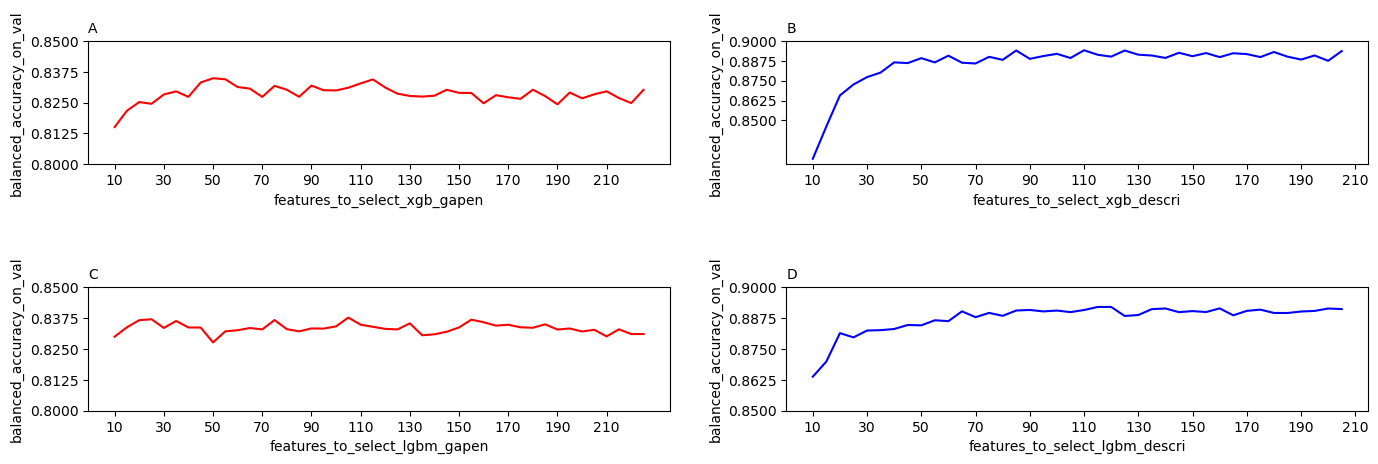

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import pylab

plt.figure()
f, ([[ax1,ax2],[ax3,ax4]]) = plt.subplots(2,2)
plt.subplots_adjust(left=0, bottom=None, right=2, top=None, wspace=None, hspace=1)

ax1.plot(range(10,226,5),score_val_xgb_gapen,color='red')
ax1.set_xticks(range(10,230,20))
ax1.set_yticks(np.linspace(0.80,0.85,5))
ax1.set_xlabel('features_to_select_xgb_gapen')
ax1.set_ylabel('balanced_accuracy_on_val')
ax1.set_title('A',fontsize=10,loc='left')

ax2.plot(range(10,208,5),score_val_xgb_descri,color='blue')
ax2.set_xticks(range(10,230,20))
ax2.set_yticks(np.linspace(0.85,0.90,5))
ax2.set_xlabel('features_to_select_xgb_descri')
ax2.set_ylabel('balanced_accuracy_on_val')
ax2.set_title('B',fontsize=10,loc='left')

ax3.plot(range(10,226,5),score_val_lgbm_gapen,color='red')
ax3.set_xticks(range(10,230,20))
ax3.set_yticks(np.linspace(0.80,0.85,5))
ax3.set_xlabel('features_to_select_lgbm_gapen')
ax3.set_ylabel('balanced_accuracy_on_val')
ax3.set_title('C',fontsize=10,loc='left')

ax4.plot(range(10,208,5),score_val_lgbm_descri,color='blue')
ax4.set_xticks(range(10,230,20))
ax4.set_yticks(np.linspace(0.85,0.90,5))
ax4.set_xlabel('features_to_select_lgbm_descri')
ax4.set_ylabel('balanced_accuracy_on_val')
ax4.set_title('D',fontsize=10,loc='left')

plt.savefig('pictures/feature_selection_test.png',dpi=500)

plt.show()